In [1]:
# Standard 
import os, sys , copy ,shutil, logging, csv, json, logging
logger = logging.getLogger()
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize

# Import all the streamm modules
from streamm import *
from streamm import values

%load_ext autoreload
%autoreload 2

In [2]:
local = resource.Resource('local')
local.load_json()

peregrine = resource.Resource('peregrine')
peregrine.load_json()

Reading in resource json file res_local.json 
Reading in resource json file res_peregrine.json 


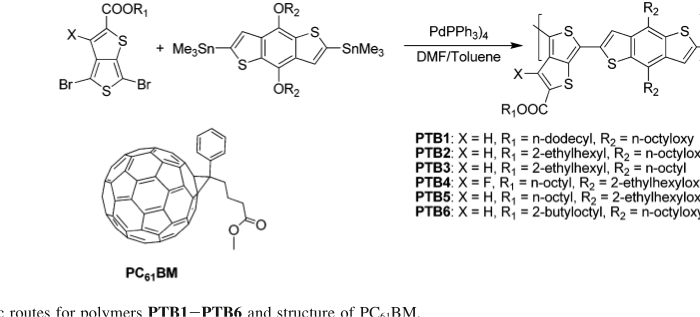

In [3]:
from IPython.display import Image
Image(filename=local.dir['home']+'/figures/PTBX.png')

In [4]:
os.getcwd()

'/Users/tkemper/Projects/DApolymers/notebooks'

for tag_i in tag_list:
    calc_i  = calculation.CalculationRes(tag_i)
    proj_i.calculations[tag_i] = calc_i

In [5]:
proj_tag = 'res_et2'
proj_i = project.Project('DAPpolymers_%s'%(proj_tag))
proj_i.load_json()

Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 


In [6]:
proj_tag = 'mol_sp2'
proj_j = project.Project('DAPpolymers_%s'%(proj_tag))
proj_j.load_json()

Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
No references found 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
No references found 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
No references found 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
No references found 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 


In [113]:
print units.convert_H_eV(1.0)

27.2113952616


In [7]:
for tag_i,calc_j in proj_j.calculations.iteritems():
    print calc_j.properties['name'] 


BDT-TPD
PCE10
PTB4
PTB7
PTB5
PCE10
PTB1
PCE10
PTB4
PTB7


In [8]:
def load_etij(calc_i):
    # 
    os.chdir(calc_i.dir['materials'])

    calc_i.et_ij = pd.read_csv("%s.csv"%calc_i.tag)

    print " len_o ",len(calc_i.et_ij)

    etdr = calc_i.et_ij.replace([np.inf, -np.inf], np.nan)
    calc_i.et_ij = etdr.dropna() #subset=['Vij','Vji'],how="all")

    print  " len after dropna ",len(calc_i.et_ij)

    calc_i.et_ij['absSij'] = calc_i.et_ij['Sij'].abs()

    #print calc_i.et_ij.columns

    et_ij3 = calc_i.et_ij[calc_i.et_ij['absSij'] > 1.e-6  ]
    calc_i.et_ij_s = et_ij3


    print  " len after absSij > 1.e-6 ",len(calc_i.et_ij_s)

 
    res_D = [x for x in calc_i.et_ij['resname_i'].values if( x[0] == 'D') ][0]

    res_A = [x for x in calc_i.et_ij['resname_i'].values if( x[0] == 'A') ][0]

    print res_D,res_A

    et_ij3.shape
    

    calc_i.et_DA = et_ij3[ (et_ij3['resname_i'] == res_D) & (et_ij3['resname_j'] == res_A) ]
    calc_i.et_DD = et_ij3[ (et_ij3['resname_i'] == res_D) & (et_ij3['resname_j'] == res_D) ]
    calc_i.et_AA = et_ij3[ (et_ij3['resname_i'] == res_A) & (et_ij3['resname_j'] == res_A) ]        

In [57]:
def sum_Sij(calc_i):
    
    t_etij = calc_i.et_ij_s
    
    t_etij_DA = calc_i.et_DA 
    t_etij_DD = calc_i.et_DD
    t_etij_AA = calc_i.et_AA 
    
    mol_n = t_etij['mol_j'].max() 
    mol_o = t_etij['mol_i'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    
    print " min %d max %d "%(mol_o,mol_n)
    
    molSIJ = {}
    molSIJ['mol_i'] = []
    molSIJ['mol_j'] = []    
    molSIJ['SIJ_N'] = []    
    molSIJ['SIJ_DA_N'] = []    
    molSIJ['SIJ_DD_N'] = []    
    molSIJ['SIJ_AA_N'] = []    
    
    N_units = 10.0 

    for mol_i in range(mol_o,mol_n+1):
        for mol_j in range(mol_o,mol_n+1):
            # print "  - mol_o,mol_n",mol_o,mol_n            
            sumSij = t_etij[ (t_etij['mol_i'] == mol_i) & (t_etij['mol_j'] == mol_j)]['absSij'].sum()/N_units            
            sumSij_DA = t_etij_DA[ (t_etij_DA['mol_i'] == mol_i) & (t_etij_DA['mol_j'] == mol_j)]['absSij'].sum()/N_units
            sumSij_DD = t_etij_DD[ (t_etij_DD['mol_i'] == mol_i) & (t_etij_DD['mol_j'] == mol_j)]['absSij'].sum()/N_units
            sumSij_AA = t_etij_AA[ (t_etij_AA['mol_i'] == mol_i) & (t_etij_AA['mol_j'] == mol_j)]['absSij'].sum()/N_units
            
            molSIJ['mol_i'].append(int(mol_i))            
            molSIJ['mol_j'].append(int(mol_j))
            molSIJ['SIJ_N'].append(float(sumSij))
            molSIJ['SIJ_DA_N'].append(float(sumSij_DA))
            molSIJ['SIJ_DD_N'].append(float(sumSij_DD))
            molSIJ['SIJ_AA_N'].append(float(sumSij_AA))

                
    calc_i.molSIJ_df = pd.DataFrame(molSIJ)

In [10]:
def find_SijMax(molSIJ_df):
    #
    molSIJ_max = {}
    molSIJ_max['mol_i'] = []
    molSIJ_max['SIJ_max'] = []
    #
    for mol_i in  molSIJ_df['mol_i'].unique():
        SIJ_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['SIJ_N'].max()
        molSIJ_max['mol_i'].append(mol_i)
        molSIJ_max['SIJ_max'].append(SIJ_max)
    #print Smol_s['Sij_N'].max(),Smol_s['sumSij'].max()
    molSIJ_max_df = pd.DataFrame(molSIJ_max)
    #
    return molSIJ_max_df

In [11]:
os.getcwd()

'/Users/tkemper/Projects/DApolymers/notebooks'

In [12]:
name_l = []
name_l.append('BDT-TPD')
name_l.append('PTB1')
name_l.append('PTB5')
name_l.append('PTB4')
name_l.append('PTB7')
name_l.append('PCE10')

In [13]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print 'proj_i.calculations[\''+tag_i+'\'].meta[\'use\'] = True '
    calc_i.meta['use'] = False 
    #print calc_i.properties['update']

proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True 
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].meta['use'] = True 
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True 
proj_i.calculations[

In [14]:
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2'].meta['use'] = True
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].meta['use'] = True
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].meta['use'] = True
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4'].meta['use'] = True

In [ ]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['use']  ):
        print calc_i.tag
        print calc_i.properties['struc_tag']
        print calc_i.properties['name']
        #
        print calc_i.dir['materials']
        
        #

In [ ]:
for tag,calc_i in proj_i.calculations.iteritems():
    calc_i.dir['materials'] = '/Users/tkemper/Projects/DApolymers/materials/'+calc_i.properties['name']
 

In [58]:
for tag_i,calc_i in proj_i.calculations.iteritems():
        #if( calc_i.meta['use']  ):

        print calc_i.tag
        print calc_i.properties['name']
        os.chdir(calc_i.dir['materials'])        
        load_etij(calc_i)

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB7
 len_o  112729
 len after dropna  112729
 len after absSij > 1.e-6  11396
D1 A23
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
PTB4
 len_o  111367
 len after dropna  111367
 len after absSij > 1.e-6  11688
D1 A23
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB5
 len_o  113889
 len after dropna  113889
 len after absSij > 1.e-6  11514
D1 A31
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
PCE10
 len_o  200108
 len after dropna  200108
 len after absSij > 1.e-6  10980
D1 A23
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
BDT-TPD
 len_o  81173
 len after dropna  81173
 len after absSij > 1.e-6  10570
D1 A2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB4
 len_o  104572
 len after dropna  104572
 len after absSij > 1.e-6  10816
D1 A23
D1_R2R2

Sum Sij's to get S_IJ

In [59]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()
    print calc_i.meta['status']
    print calc_i.properties['name']
    sum_Sij(calc_i)
    

0 192
finished
PTB7
 min 0 max 192 
0 192
finished
PTB4
 min 0 max 192 
0 192
finished
PTB5
 min 0 max 192 
0 172
ready
PCE10
 min 0 max 172 
1 197
finished
BDT-TPD
 min 1 max 197 
0 192
finished
PTB4
 min 0 max 192 
0 192
finished
PTB7
 min 0 max 192 
0 172
finished
PTB1
 min 0 max 172 
0 172
finished
PCE10
 min 0 max 172 
0 172
finished
PCE10
 min 0 max 172 


Add molecule energies to df

In [60]:
for tag_j,calc_j in proj_j.calculations.iteritems():
    os.chdir(calc_j.dir['launch'])
    calc_j.mol_en = pd.read_csv("mol_en.csv")

In [61]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print tag_i


D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2


Change mol energy to eV

In [62]:
for key_i in calc_j.mol_en.columns:
    print 'en_keys.append(\''+key_i+'\')' #,calc_i.df_ij_ji[key_i].mean()

en_keys.append('tag')
en_keys.append('g_i')
en_keys.append('total')
en_keys.append('HOMO')
en_keys.append('LUMO')


In [63]:
en_keys = []
en_keys.append('total')
en_keys.append('HOMO')
en_keys.append('LUMO')

In [64]:
for tag_j,calc_j in proj_j.calculations.iteritems():
    print tag_j

    for key_i in  en_keys:
        print ' - ',key_i
        calc_j.mol_en[key_i] = calc_j.mol_en[key_i].apply(lambda x: units.convert_H_eV(x))
    print ''
    print ''    

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_mol_sp2
 -  total
 -  HOMO
 -  LUMO


D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193

In [65]:
for tag_j,calc_j in proj_j.calculations.iteritems():
    print tag_j
    print calc_j.mol_en['HOMO'].mean()
    print ''
    print ''   

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.85382370113


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3_mol_sp2
-6.32698110994


D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_mol_sp2
-6.35930984023


D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.46748703609


D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.14770803853


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4_mol_sp2
-6.32698110994


D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.24119405628


D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.32709648787


D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
-6.35930984023


D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_pr

In [ ]:
calc_i = proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2']

In [66]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print calc_i.tag
    calc_j = None 
    for tag_j,calc_jo in  proj_j.calculations.iteritems():
        tag_ji =  tag_j.replace('_mol_sp2','')
        # print " -- ",tag_ji
        if( tag_ji == calc_i.tag ):
            calc_j = calc_jo
    print calc_j.tag

    print calc_i.molSIJ_df['mol_i'].min(),calc_i.molSIJ_df['mol_i'].max()

    print len(calc_i.molSIJ_df)

    calc_i.molSIJ_df['mol_i'] =  calc_i.molSIJ_df['mol_i'].apply(lambda x: x - calc_i.molSIJ_df['mol_i'].min() )
    calc_i.molSIJ_df['mol_j'] =  calc_i.molSIJ_df['mol_j'].apply(lambda x: x - calc_i.molSIJ_df['mol_j'].min() )    

    print calc_i.molSIJ_df['mol_j'].min(),calc_i.molSIJ_df['mol_j'].max()

    print calc_i.molSIJ_df.columns

    print calc_j.mol_en['g_i'].min(),calc_j.mol_en['g_i'].max()

    calc_j.mol_en['mol_i'] =  calc_j.mol_en['g_i'] #.apply(lambda x: x+1)

    if( calc_j.mol_en['mol_i'].min() != calc_i.molSIJ_df['mol_i'].min() ):
        print "error 1 ",calc_j.mol_en['mol_i'].min() , calc_i.molSIJ_df['mol_i'].min()
    if( calc_j.mol_en['mol_i'].max() != calc_i.molSIJ_df['mol_i'].max() ):
        print "error 2",calc_j.mol_en['mol_i'].max() , calc_i.molSIJ_df['mol_i'].max() 

    calc_i.molSIJ_df['mol_i'].min()

    print calc_j.mol_en.columns

    molSIJ_en = pd.merge(calc_i.molSIJ_df,calc_j.mol_en,on=['mol_i'])
    molSIJ_en_i = molSIJ_en.rename(columns={'total':'total_i','HOMO':'HOMO_i','LUMO':'LUMO_i'})
    mol_en_j = calc_j.mol_en.rename(columns={'mol_i':'mol_j','g_i':'g_j','total':'total_j','HOMO':'HOMO_j','LUMO':'LUMO_j'})
    calc_i.molSIJ_en_ij = pd.merge(molSIJ_en_i,mol_en_j,on=['mol_j'])

    print calc_i.dir['materials']

    os.chdir(calc_i.dir['materials'])
    file_name = "%s_mol.csv"%(tag_i)
    calc_i.files['output']['mol_ij'] = file_name
    calc_i.molSIJ_en_ij.to_csv(file_name, sep=',', encoding='utf-8')
    

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
0 192
37249
0 192
Index([u'SIJ_AA_N', u'SIJ_DA_N', u'SIJ_DD_N', u'SIJ_N', u'mol_i', u'mol_j'], dtype='object')
0 192
Index([u'tag', u'g_i', u'total', u'HOMO', u'LUMO', u'mol_i'], dtype='object')
/Users/tkemper/Projects/DApolymers/materials/PTB7
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3_mol_sp2
0 192
37249
0 192
Index([u'SIJ_AA_N', u'SIJ_DA_N', u'SIJ_DD_N', u'SIJ_N', u'mol_i', u'mol_j'], dtype='object')
0 192
Index([u'tag', u'g_i', u'total', u'HOMO', u'LUMO', u'mol_i'], dtype='object')
/Users/tkemper/Projects/DApolymers/materials/PTB4
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol_sp2
0 192
37249
0 

In [86]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print calc_i.tag
    print calc_i.molSIJ_en_ij['SIJ_N'].mean(),calc_i.molSIJ_en_ij['SIJ_DA_N'].mean()
 

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
4.47894178636e-05 1.13087554565e-05
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
4.47657901689e-05 1.14531096137e-05
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
4.88025263497e-05 1.18224781068e-05
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
2.22419543586e-05 5.63585235056e-06
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
3.88307400861e-05 9.10080818882e-06
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
4.17831629305e-05 1.06850753846e-05
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
4.40819235416e-05 1.1120077586e-05
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2
5.25675755288e-05 1.33839478766e-05
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remi

Load mol_ij dataframes and calculate  VIJ

In [ ]:
#gamma = 1.1667

#gamma = 1.16762329    

In [71]:
def calc_VIJ(row_i):
    gamma = 1.168
    e_bar = -0.5*(row_i['HOMO_i'] + row_i['HOMO_j'])
    return gamma*row_i['SIJ_N']*e_bar
def calc_VIJ_DA(row_i):
    gamma = 1.168
    e_bar = -0.5*(row_i['HOMO_i'] + row_i['HOMO_j'])
    return gamma*row_i['SIJ_DA_N']*e_bar

def calc_VIJ_AA(row_i):
    gamma = 1.168
    e_bar = -0.5*(row_i['HOMO_i'] + row_i['HOMO_j'])
    return gamma*row_i['SIJ_AA_N']*e_bar

def calc_VIJ_DD(row_i):
    gamma = 1.168
    e_bar = -0.5*(row_i['HOMO_i'] + row_i['HOMO_j'])
    return gamma*row_i['SIJ_DD_N']*e_bar



In [68]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    print tag_i
    calc_i.molSIJ_en_ij['VIJ'] =  calc_i.molSIJ_en_ij[['HOMO_i','HOMO_j','SIJ_N']].apply(calc_VIJ,axis=1)
        

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2


In [72]:
gamma = 1.168
for tag_i,calc_i in proj_i.calculations.iteritems():
    print tag_i
    calc_i.molSIJ_en_ij['VIJ_DA'] =  calc_i.molSIJ_en_ij[['HOMO_i','HOMO_j','SIJ_DA_N']].apply(calc_VIJ_DA,axis=1)
    calc_i.molSIJ_en_ij['VIJ_DD'] =  calc_i.molSIJ_en_ij[['HOMO_i','HOMO_j','SIJ_DD_N']].apply(calc_VIJ_DD,axis=1)
    calc_i.molSIJ_en_ij['VIJ_AA'] =  calc_i.molSIJ_en_ij[['HOMO_i','HOMO_j','SIJ_AA_N']].apply(calc_VIJ_AA,axis=1)    

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2


In [73]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    #if( calc_i.meta['status'] == 'processed' ):
    print calc_i.dir['materials']

    os.chdir(calc_i.dir['materials'])
    file_name = "%s_mol.csv"%(tag_i)
    calc_i.files['output']['mol_ij'] = file_name
    calc_i.molSIJ_en_ij.to_csv(file_name, sep=',', encoding='utf-8')
    

/Users/tkemper/Projects/DApolymers/materials/PTB7
/Users/tkemper/Projects/DApolymers/materials/PTB4
/Users/tkemper/Projects/DApolymers/materials/PTB5
/Users/tkemper/Projects/DApolymers/materials/PCE10
/Users/tkemper/Projects/DApolymers/materials/BDT-TPD
/Users/tkemper/Projects/DApolymers/materials/PTB4
/Users/tkemper/Projects/DApolymers/materials/PTB7
/Users/tkemper/Projects/DApolymers/materials/PTB1
/Users/tkemper/Projects/DApolymers/materials/PCE10
/Users/tkemper/Projects/DApolymers/materials/PCE10


In [74]:
print calc_i.molSIJ_en_ij.columns

Index([u'SIJ_AA_N', u'SIJ_DA_N', u'SIJ_DD_N', u'SIJ_N', u'mol_i', u'mol_j',
       u'tag_x', u'g_i', u'total_i', u'HOMO_i', u'LUMO_i', u'tag_y', u'g_j',
       u'total_j', u'HOMO_j', u'LUMO_j', u'VIJ', u'VIJ_DA', u'VIJ_DD',
       u'VIJ_AA'],
      dtype='object')


In [35]:
IJ_maxs = {}
IJ_maxs['Polymer'] = []
IJ_maxs['SIJ_df'] = []
IJ_maxs['VIJ_df'] = []

In [75]:
def find_Max(molSIJ_df):
    #
    molSV_max = {}
    molSV_max['mol_i'] = []
    molSV_max['SIJ_max'] = []
    molSV_max['SIJ_DA_max'] = []
    molSV_max['SIJ_DD_max'] = []
    molSV_max['SIJ_AA_max'] = []


    molSV_max['VIJ_max'] = []
    molSV_max['VIJ_DA_max'] = []
    molSV_max['VIJ_DD_max'] = []
    molSV_max['VIJ_AA_max'] = []



    #
    for mol_i in  molSIJ_df['mol_i'].unique():
        SIJ_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['SIJ_N'].max()
        SIJ_DA_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['SIJ_DA_N'].max()
        SIJ_DD_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['SIJ_DD_N'].max()
        SIJ_AA_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['SIJ_AA_N'].max()
        
        VIJ_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['VIJ'].max()
        VIJ_DA_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['VIJ_DA'].max()        
        VIJ_DD_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['VIJ_DD'].max()        
        VIJ_AA_max = molSIJ_df[ molSIJ_df['mol_i'] == mol_i ]['VIJ_AA'].max()                
        #
        molSV_max['mol_i'].append(mol_i)
        molSV_max['SIJ_max'].append(SIJ_max)
        molSV_max['SIJ_DA_max'].append(SIJ_DA_max)
        molSV_max['SIJ_DD_max'].append(SIJ_DD_max)
        molSV_max['SIJ_AA_max'].append(SIJ_AA_max)

        molSV_max['VIJ_max'].append(VIJ_max)
        molSV_max['VIJ_DA_max'].append(VIJ_DA_max)        
        molSV_max['VIJ_DD_max'].append(VIJ_DD_max)        
        molSV_max['VIJ_AA_max'].append(VIJ_AA_max)        


    #
    return pd.DataFrame(molSV_max)

In [76]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    #if( calc_i.meta['status'] == 'processed' ):

    print calc_i.properties['name']

    calc_i.molSV_max_df = find_Max(calc_i.molSIJ_en_ij)

    print calc_i.properties['name'],calc_i.molSV_max_df['SIJ_max'].mean(),calc_i.molSV_max_df['VIJ_max'].mean()
    print ''
    print ''    


PTB7
PTB7 0.00393743937306 0.0296997935793


PTB4
PTB4 0.00380250890674 0.0281693961233


PTB5
PTB5 0.0039520127513 0.0283182765831


PCE10
PCE10 0.00149420759538 0.0110361160459


BDT-TPD
BDT-TPD 0.00347209280203 0.0277592989849


PTB4
PTB4 0.00354062207772 0.0262379485354


PTB7
PTB7 0.0038740084456 0.0292191686314


PTB1
PTB1 0.00387174304046 0.028146153296


PCE10
PCE10 0.00211766246243 0.0156307537217


PCE10
PCE10 0.00152186326744 0.0112448504046




In [38]:
for name_i in name_l:

    for tag_i,calc_i in proj_i.calculations.iteritems():
        if( calc_i.properties['name'] == name_i ):
            #if( calc_i.meta['status'] == 'processed' ):
            print tag_i
            print calc_i.properties['name'],calc_i.molSV_max_df['SIJ_max'].mean(),calc_i.molSV_max_df['VIJ_max'].mean()



D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2
BDT-TPD 0.00347209280203 0.0277592989849
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2
PTB1 0.00387174304046 0.028146153296
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB5 0.0039520127513 0.0283182765831
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
PTB4 0.00380250890674 0.0281693961233
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB4 0.00354062207772 0.0262379485354
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2
PTB7 0.00393743937306 0.0296997935793
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3
PTB7 0.0038740084456 0.0292191686314
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2_res_et3
PCE10 0.00149420759538 0.0110361160459
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_pr

In [39]:
os.chdir('/Users/tkemper/Projects/DApolymers/tables/')

In [40]:
SIJ_l = 'Polymer & $<S_{IJ}>$ & $\sigma(S_{IJ})$  & $<V_{IJ}>$ & $\sigma(V_{IJ})$   \\\\ \hline \n'
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i

    SIJ_l += '%s  '%(calc_i.properties['name'])
    mean = calc_i.molSV_max_df['SIJ_max'].mean()
    std = calc_i.molSV_max_df['SIJ_max'].std()
    SIJ_l += '& %8.4f & %6.2e '%(mean,std)
    mean = calc_i.molSV_max_df['VIJ_max'].mean()
    std = calc_i.molSV_max_df['VIJ_max'].std()
    SIJ_l += '& %8.4f & %6.2e '%(mean,std)
    SIJ_l += ' \\\\ \n'


print SIJ_l
f = open('molSIJ_max.tex','w')
f.write(SIJ_l)
f.close()


D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
Polymer & $<S_{IJ}>$ & $\sigma(S_{IJ})$  & $<V_{IJ}>$ & $\sigma(V_{IJ})$   \\ \hline 
BDT-TPD  &   0.0035 & 1.58e-03 &   0.0278 & 1.26e-02  \\ 
PTB1  &   0.0039 & 1.69e-03 &   0.0281 & 1.22e-02  \\ 
PTB5  &   0.0040 & 1.88e-03 &   0.0283 & 1.33e-02  \\ 
PTB4  &   0.0038 & 1.83e-03 &   0.0282 & 1.35e-02  \\ 
PTB7  &   0.0039 & 1.83e-03 &   0.0292 & 1.37e-02  \\ 
PCE10  &   0.0021 & 9.61e-04 &   0.0156 & 7.03e-03  \\ 



In [94]:
os.chdir('/Users/tkemper/Projects/DApolymers/figures/')

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
BDT-TPD
BDT-TPD 0.0277592989849
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
PTB1
PTB1 0.028146153296
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
PTB5
PTB5 0.0283182765831
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
PTB4
PTB4 0.0281693961233
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
PTB7
PTB7 0.0292191686314
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
PCE10
PCE10 0.0156307537217


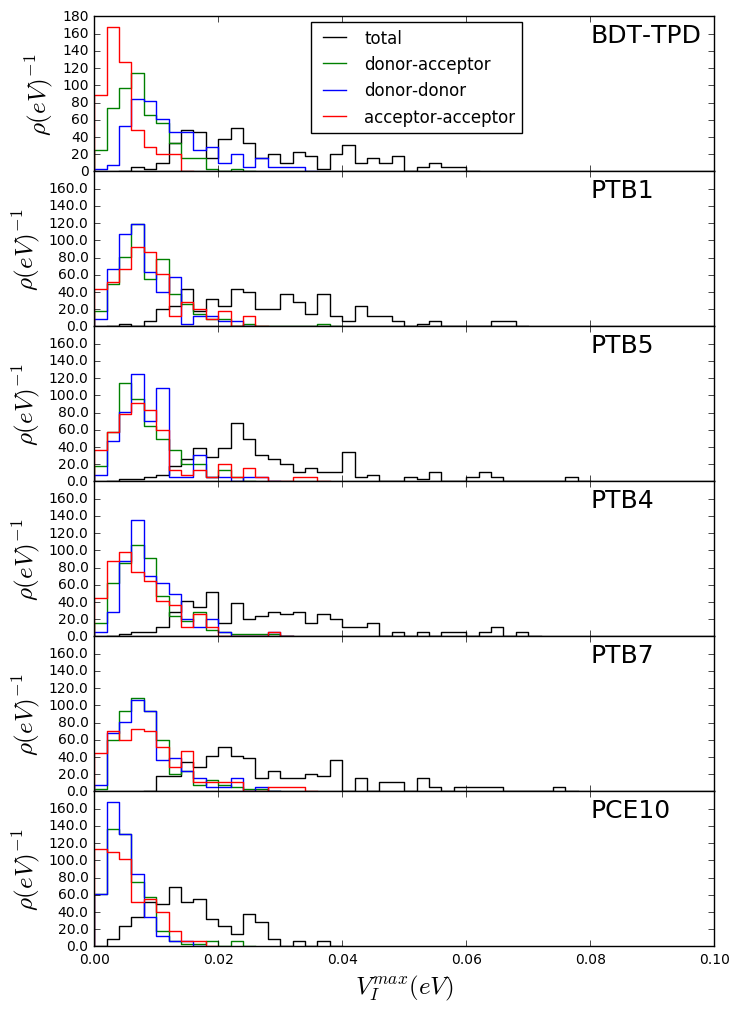

In [95]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 12
fontsz_text = 18

fig, ax = plt.subplots(6,sharex=True)

i = 0 


for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i

    print calc_i.properties['name']
    Polymer = calc_i.properties['name']
    mean = calc_i.molSV_max_df['VIJ_max'].mean()
    # 
    print Polymer,mean
    # mol_SIJ['SIJ_max'].hist(ax=ax[i], bins=50, bottom=0.1)
    # ax.set_yscale('log')    


    val_i = values.Values('VIJ_max',calc_i.molSV_max_df['VIJ_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.002)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps",label='total')

    val_i = values.Values('VIJ_DA_max',calc_i.molSV_max_df['VIJ_DA_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.002)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'g-',ls = "steps",label='donor-acceptor')

    val_i = values.Values('VIJ_DD_max',calc_i.molSV_max_df['VIJ_DD_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.002)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'b-',ls = "steps",label='donor-donor')


    val_i = values.Values('VIJ_AA_max',calc_i.molSV_max_df['VIJ_AA_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.002)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'r-',ls = "steps",label='acceptor-acceptor')



    ax[i].set_xlim(0,0.10)
    ax[i].set_ylim(0.0,180.)
    ax[i].text(0.08,150.0,Polymer,fontsize=fontsz_text)

    if( i > 0 ):
        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    


    ax[i].set_ylabel(r'$\rho (eV)^{-1}$',fontsize=fontsz_text)
    i += 1

ax[0].legend(loc=(0.35,0.250),prop={'size':fontsz_leg})


fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)
ax[i-1].set_xlabel(r'$V_{I}^{max}(eV)$',fontsize=fontsz_text)


fig.savefig('molVIJmax_v6.pdf',format='pdf')

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
BDT-TPD 0.00347209280203
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
PTB1 0.00387174304046
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
PTB5 0.0039520127513
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
PTB4 0.00380250890674
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
PTB7 0.0038740084456
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
PCE10 0.00211766246243


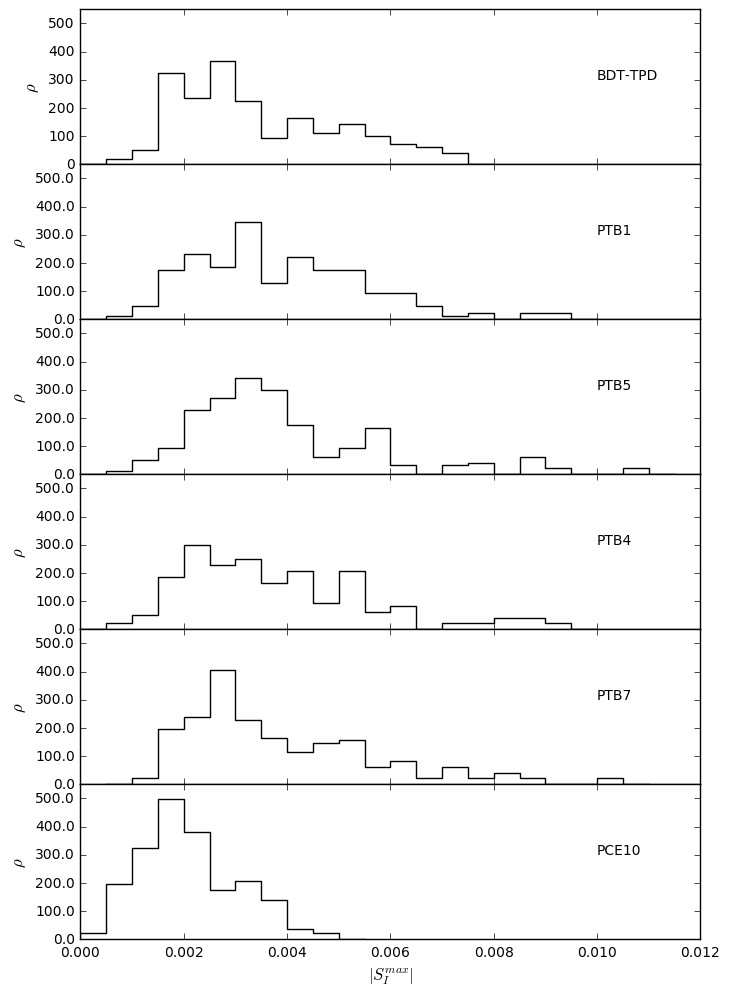

In [55]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 12
fontsz_text = 12

fig, ax = plt.subplots(6,sharex=True)

i = 0 



for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i

    Polymer = calc_i.properties['name']
    mean = calc_i.molSV_max_df['SIJ_max'].mean()
    # 
    print Polymer,mean
    # mol_SIJ['SIJ_max'].hist(ax=ax[i], bins=50, bottom=0.1)
    # ax.set_yscale('log')    


    val_i = values.Values('SIJ_max',calc_i.molSV_max_df['SIJ_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))

    val_i.calc_stats()
    val_i.set_bins(.0005)
    val_i.calc_hist()

    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps")

    ax[i].set_xlim(0,0.012)
    ax[i].set_ylim(0.0,550.)
    ax[i].text(0.01,300.0,Polymer)

    if( i > 0 ):

        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    


    ax[i].set_ylabel(r'$\rho$',fontsize=fontsz_text)


    i += 1
ax[i-1].set_xlabel(r'$|S_{I}^{max}|$',fontsize=fontsz_text)


fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)



fig.savefig('SIJmax_v2.pdf',format='pdf')


    

In [99]:
proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2'].properties['KT'] =  0.016804 
proj_i.calculations['D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2'].properties['KT'] =  0.019055 
proj_i.calculations['D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].properties['KT'] =  0.019604 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].properties['KT'] =  0.018125 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3'].properties['KT'] =  0.017821 
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4'].properties['KT'] =  0.011131 

In [100]:
for tag_i,calc_i in proj_i.calculations.iteritems(): 
    print calc_i.properties['KT']

0.000665595820126
0.018125
0.019604
0.000323830247831
0.016804
2.45530312271e+22
0.017821
0.019055
0.011131
0.00033187282539


In [101]:
os.chdir('/Users/tkemper/Projects/DApolymers/tables')

In [109]:
table_lines = '  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $K_{T}$ \\\\ \hline \n'
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i
    table_lines += ' %s '%(name_i)
    table_lines += '& %8.4f (%8.2e) '%(calc_i.molSV_max_df['VIJ_max'].mean(),calc_i.molSV_max_df['VIJ_max'].std())
    table_lines += '& %8.4f '%calc_i.properties['KT']
    table_lines += '\\\\ \n'
    
print table_lines    
f = open('VIJmax.tex','w')
f.write(table_lines)
f.close()

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $K_{T}$ \\ \hline 
 BDT-TPD &   0.0278 (1.26e-02) &   0.0168 \\ 
 PTB1 &   0.0281 (1.22e-02) &   0.0191 \\ 
 PTB5 &   0.0283 (1.33e-02) &   0.0196 \\ 
 PTB4 &   0.0282 (1.35e-02) &   0.0181 \\ 
 PTB7 &   0.0292 (1.37e-02) &   0.0178 \\ 
 PCE10 &   0.0156 (7.03e-03) &   0.0111 \\ 



In [111]:
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print name_i,calc_i.properties['KT']/calc_i.molSV_max_df['VIJ_max'].mean()

BDT-TPD 0.605346698746
PTB1 0.677001926324
PTB5 0.692273766818
PTB4 0.643428773577
PTB7 0.60990783909
PCE10 0.712121769571


In [115]:
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    Polymer = calc_i.properties['name']
    # 
    print Polymer,calc_i.molSIJ_en_ij['SIJ_N'].mean(),calc_i.molSIJ_en_ij['VIJ'].mean()

 BDT-TPD 3.88307400861e-05 0.00031068399356
PTB1 5.25675755288e-05 0.000382559964537
PTB5 4.88025263497e-05 0.00035003628389
PTB4 4.47657901689e-05 0.000332167858866
PTB7 4.40819235416e-05 0.000332630489339
PCE10 2.97206326974e-05 0.000219396171791


In [117]:
    print calc_i.molSIJ_en_ij.columns

Index([u'SIJ_AA_N', u'SIJ_DA_N', u'SIJ_DD_N', u'SIJ_N', u'mol_i', u'mol_j',
       u'tag_x', u'g_i', u'total_i', u'HOMO_i', u'LUMO_i', u'tag_y', u'g_j',
       u'total_j', u'HOMO_j', u'LUMO_j', u'VIJ', u'VIJ_DA', u'VIJ_DD',
       u'VIJ_AA'],
      dtype='object')


In [218]:
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    mol_ij = calc_i.molSIJ_en_ij

    mol_n = mol_ij['mol_j'].max() 
    mol_o = mol_ij['mol_j'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()    

    print mol_o,mol_n

    VI_n = {}
    for mol_i in range(mol_o,mol_n+1):
        VI_n[mol_i] = []
        
        VI_s_i = mol_ij[ (mol_ij['mol_i'] == mol_i ) ]['VIJ'].sort_values(ascending=False)
        VI_tot = VI_s_i.sum()
        
        for n_i in range(mol_o,mol_n+1):
            pVIJ_n = VI_s_i[0:n_i].sum()/VI_tot
            
            VI_n[mol_i].append(pVIJ_n)
            
    calc_i.VI_df = pd.DataFrame(VI_n)

0 196
0 172
0 192
0 192
0 192
0 172


In [284]:
os.chdir('/Users/tkemper/Projects/DApolymers/figures')

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10


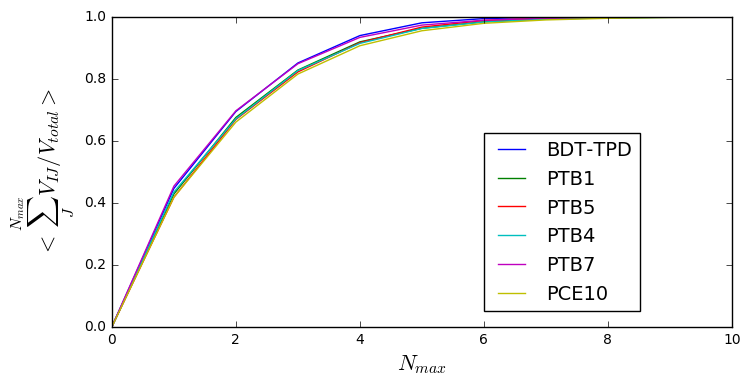

In [286]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 12
fontsz_text = 16

fig, ax = plt.subplots(1,sharex=True)

i = 0
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i
    
    VI_mean =  calc_i.VI_df.mean(axis=1) #,VI_df[n_i].std(axis=1)
    VI_y = VI_mean.values
    #VI_y = VI_mean.apply(np.log10)

    VI_x = range(len(VI_y))
    VI_std =  calc_i.VI_df.std(axis=1) #,VI_df[n_i].std(axis=1)

    #VI_mean[name_i].plot(ax=ax)
    ax.plot(VI_x,VI_y,label=name_i)
    

ax.set_xlabel(r'$N_{max}$',fontsize=fontsz_text)
ax.set_ylabel(r'$<\sum_J^{N_{max}}V_{IJ}/V_{total}>$',fontsize=fontsz_text)
    
ax.legend(loc=(0.6,0.050),prop={'size':14})    
ax.set_xlim(0,10)
fig.set_size_inches(8.0, 4.0)



In [287]:
fig_name = "Vave_Nmax.pdf"
print fig_name
fig.savefig(fig_name,format='pdf')

Vave_Nmax.pdf



Calculate
$$\bar{V_{I}} = \frac{1}{N} \sum_J^N V_{IJ}$$

where N is 8

In [258]:
n_i = 8 
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    mol_ij = calc_i.molSIJ_en_ij

    mol_n = mol_ij['mol_j'].max() 
    mol_o = mol_ij['mol_j'].min()  #calc_i.et_ij_s['mol_i'].min(),calc_i.et_ij_s['mol_i'].max()    

    print mol_o,mol_n

    VI_n_ave = []
    for mol_i in range(mol_o,mol_n+1):
        
        VI_s_i = mol_ij[ (mol_ij['mol_i'] == mol_i ) ]['VIJ'].sort_values(ascending=False)
        
        pVIJ_n = VI_s_i[1:n_i+1].mean() 
            
        #VI_n_ave[mol_i].append(pVIJ_n)
        VI_n_ave.append(pVIJ_n)

            
    #calc_i.VIave_df = pd.DataFrame(VI_n_ave)
    calc_i.VI_n_ave = np.array(VI_n_ave)

0 196
0 172
0 192
0 192
0 192
0 172


In [260]:
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print name_i,calc_i.VI_n_ave.mean(),calc_i.VI_n_ave.std()

BDT-TPD 0.00417942552504 0.00147268398887
PTB1 0.00474522905392 0.00199614213417
PTB5 0.00489871822743 0.00184916600198
PTB4 0.00447935251582 0.00169035023854
PTB7 0.00436414433482 0.00171908858007
PCE10 0.00278159645524 0.00132946296753


In [306]:
os.chdir('/Users/tkemper/Projects/DApolymers/figures')

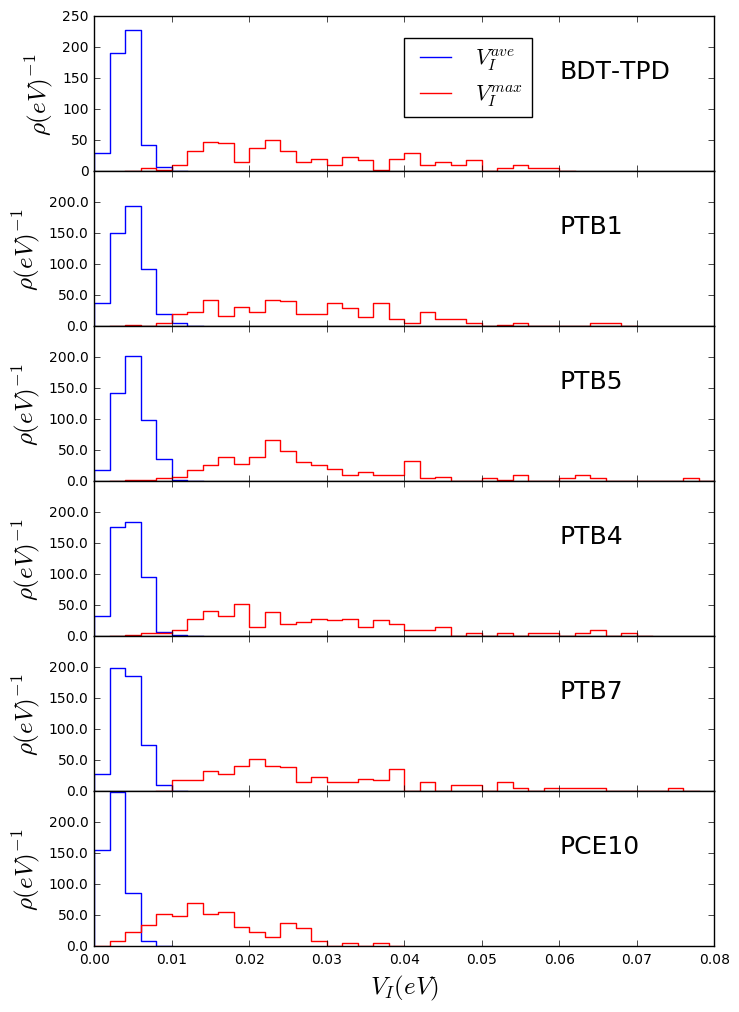

In [307]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 16
fontsz_text = 18

fig, ax = plt.subplots(6,sharex=True)


#ax.plot(rgy_sq_vals.bin_val,rgy_sq_vals.hist_bin)
#ax.bar(rgy_sq_vals.bins_cent, rgy_sq_vals.hist_cent , align='center', width=rgy_sq_vals.bin_size)
i = 0
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o

    val_i = values.Values('V_ave',calc_i.VI_n_ave)    
    val_i.calc_stats()
    val_i.set_bins(0.002)
    val_i.calc_hist()
    #fig, ax = plt.subplots(1)
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'b-',ls = "steps",label=r'$V_I^{ave}$')
    

    val_i = values.Values('VIJ_max',calc_i.molSV_max_df['VIJ_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))
    val_i.calc_stats()
    val_i.set_bins(.002)
    val_i.calc_hist()
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'r-',ls = "steps",label='$V_I^{max}$')


    ax[i].set_xlim(0,0.08)
    ax[i].set_ylim(0.0,250.)
    ax[i].text(0.06,150.0,name_i,fontsize=fontsz_text)

    if( i > 0 ):
        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    


    ax[i].set_ylabel(r'$\rho (eV)^{-1}$',fontsize=fontsz_text)
    i += 1

ax[0].legend(loc=(0.5,0.350),prop={'size':fontsz_leg})


fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)
ax[i-1].set_xlabel(r'$V_{I}(eV)$',fontsize=fontsz_text)


fig.savefig('VIJave_v1.pdf',format='pdf')    

In [291]:
os.chdir('/Users/tkemper/Projects/DApolymers/tables')

In [292]:
table_lines = '  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $<V_{I}^{ave}>$ ($\sigma$)  & $K_{T}$ \\\\ \hline \n'
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i
    table_lines += ' %s '%(name_i)
    table_lines += '& %8.4f (%8.2e) '%(calc_i.molSV_max_df['VIJ_max'].mean(),calc_i.molSV_max_df['VIJ_max'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.VI_n_ave.mean(),calc_i.VI_n_ave.std())
    table_lines += '& %8.4f '%calc_i.properties['KT']
    table_lines += '\\\\ \n'
    
print table_lines    
f = open('VIJmaxave.tex','w')
f.write(table_lines)
f.close()

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $<V_{I}^{ave}>$ ($\sigma$)  & $K_{T}$ \\ \hline 
 BDT-TPD &   0.0278 (1.26e-02) &   0.0042 (1.47e-03) &   0.0168 \\ 
 PTB1 &   0.0281 (1.22e-02) &   0.0047 (2.00e-03) &   0.0191 \\ 
 PTB5 &   0.0283 (1.33e-02) &   0.0049 (1.85e-03) &   0.0196 \\ 
 PTB4 &   0.0282 (1.35e-02) &   0.0045 (1.69e-03) &   0.0181 \\ 
 PTB7 &   0.0292 (1.37e-02) &   0.0044 (1.72e-03) &   0.0178 \\ 
 PCE10 &   0.0156 (7.03e-03) &   0.0028 (1.33e-03) &   0.0111 \\ 



In [302]:
 float(calc_i.properties['KT'])/calc_i.molSV_max_df['VIJ_max'].mean()

0.7121217695706924

In [301]:
table_lines = '  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $<V_{I}^{ave}>$ ($\sigma$)  & $K_{T}$ \\\\ \hline \n'
for name_i in name_l:
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print  calc_i.tag  ,name_i
    table_lines += ' %s '%(name_i)
    table_lines += '& %8.4f (%8.2e) '%(calc_i.molSV_max_df['VIJ_max'].mean(),calc_i.molSV_max_df['VIJ_max'].std())
    table_lines += '& %8.4f (%8.2e) '%(calc_i.VI_n_ave.mean(),calc_i.VI_n_ave.std())
    table_lines += '& %8.4f '%calc_i.properties['KT']
    table_lines += '& %8.4f '%(calc_i.molSV_max_df['VIJ_max'].mean()/calc_i.VI_n_ave.mean())

    table_lines += '& %8.4f '%(float(calc_i.properties['KT'])/calc_i.molSV_max_df['VIJ_max'].mean())
    table_lines += '& %8.4f '%(float(calc_i.properties['KT'])/calc_i.VI_n_ave.mean())
    table_lines += '\\\\ \n'
    
print table_lines    
f = open('VIJmaxave_v2.tex','w')
f.write(table_lines)
f.close()

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 PTB1
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 PTB5
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB4
D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_res_et3 PTB7
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et4 PCE10
  Polymer & $<V_{I}^{max}>$ ($\sigma$) & $<V_{I}^{ave}>$ ($\sigma$)  & $K_{T}$ \\ \hline 
 BDT-TPD &   0.0278 (1.26e-02) &   0.0042 (1.47e-03) &   0.0168 &   6.6419 &   0.6053 &   4.0206 \\ 
 PTB1 &   0.0281 (1.22e-02) &   0.0047 (2.00e-03) &   0.0191 &   5.9315 &   0.6770 &   4.0156 \\ 
 PTB5 &   0.0283 (1.33e-02) &   0.0049 (1.85e-03) &   0.0196 &   5.7808 &   0.6923 &   4.0019 \\ 
 PTB4 &   0.0282 (1.35e-02) &   0.0045 (1.69e-03) &   0.0181 &   6.2887 &   0.6434 &   4.0463 \\ 
 PTB7

In [ ]:
for name_i in name_l:
    calc_i = None 
    for tag_i,calc_o in proj_i.calculations.iteritems():
        if( calc_o.properties['name'] == name_i and calc_o.meta['use'] ):
            calc_i = calc_o
    print len(calc_i.VI_n_ave)
    

In [56]:
for tag,calc_i in proj_i.calculations.iteritems():
    os.chdir(calc_i.dir['notebook'])
    calc_i.dump_json()
os.chdir(proj_i.dir['notebook'])
proj_i.dump_json()

{'files': {u'templates': {}, u'input': {u'cply': u'D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2.cply'}, u'output': {u'pairs_residue': u'pairs_residue.csv', u'log': u'D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2.log', u'group_residue': u'group_residue.csv', u'mol_ij': 'D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_mol.csv', u'et_sims': u'et_sims.csv', u'et': u'et.csv', u'dr': u'dr.csv', u'compressed': u'D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2_output.tgz'}, u'data': {}, u'scripts': {}}, 'meta': {u'status': u'finished', u'use': False, u'resource': u'peregrine', u'update': u'finished', u'date': u'2016-12-12T13:00:00.089533', u'software': u'streamm_calc'}, 'references': {}, 'units': {u'distance': u'angstroms', u'angle': u'radians'}, 'data': {}, 'properties': {u'struc_tag': u'D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193', u'compress_sufix': u'tgz', u'name': u'PTB7',

In [ ]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 12
fontsz_text = 12

fig, ax = plt.subplots(3,sharex=True)

i = 0 
ax[2].set_xlabel(r'$|S_{IJ}^{max}|$')



for Polymer,mol_SIJ in SIJmax_df.values:
    print Polymer,mol_SIJ['SIJ_max'].mean()
    # mol_SIJ['SIJ_max'].hist(ax=ax[i], bins=50, bottom=0.1)
    # ax.set_yscale('log')    
    
    
    val_i = values.Values('SIJ_max',mol_SIJ['SIJ_max'].values)
    #val_i = values.Values('cosine',dih_df['cosine'].apply(lambda x: np.rad2deg(np.arccos(abs(x)))))

    val_i.calc_stats()
    val_i.set_bins(.0005)
    val_i.calc_hist()
    
    ax[i].plot(val_i.bins_steps,val_i.hist_steps,'k-',ls = "steps")
    
    ax[i].set_xlim(0,0.012)
    ax[i].set_ylim(0.0,500.)
    ax[i].text(0.01,300.0,Polymer)
    
    if( i > 0 ):

        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    


    ax[i].set_ylabel(r'$\rho$')


    i += 1

fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)



fig.savefig('SIJmax_v1.pdf',format='pdf')


    

In [ ]:
ms = 3
led_x = 0.015
led_y = 0.001
fontsz_leg = 12
fontsz_text = 12


gamma_i = proj_i.coef_DDAA


fig,ax = plt.subplots(3,sharex=True)
ax[2].set_xlabel(r'$|S_{ij}|$')
    
i = 0     
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['status'] == 'processed' ):
        print calc_i.tag
        name_i = str(calc_i.properties['name'])  
        print name_i
        
        ax[i].set_ylabel(r'$V_{ij}$')


        absSij_DA = calc_i.et_DA['absSij'].values

        n_zeros = np.zeros(len(absSij_DA))
        
        Ei_DA = calc_i.et_DA['HOMO_i'].values #apply(lambda x: np.log10(x)) #values
        Ej_DA = calc_i.et_DA['HOMO_j'].values #apply(lambda x: np.log10(x)) #values
        Vij_DA = calc_i.et_DA['Vij'].values #apply(lambda x: np.log10(x)) #values

        ax[i].plot(absSij_DA,Vij_DA,'*k',ms=ms)
        f_x = calc_S_eiejV(gamma_i, absSij_DA, Ei_DA, Ej_DA) 
        ax[i].plot(absSij_DA,f_x,'-k',ms=ms)
        #ax[i].plot(n_zeros,n_zeros,'*-k',label=r'DA ($\gamma$=%6.2f)'%(gamma_i[0]),ms=ms)
        ax[i].plot(n_zeros,n_zeros,'*-k',label=r'DA',ms=ms)



        absSij_AA = calc_i.et_AA['absSij'].values #apply(lambda x: np.log10(x)) #values    
        Ei_AA = calc_i.et_AA['HOMO_i'].values #apply(lambda x: np.log10(x)) #values
        Ej_AA = calc_i.et_AA['HOMO_j'].values #apply(lambda x: np.log10(x)) #values
        Vij_AA = calc_i.et_AA['Vij'].values #apply(lambda x: np.log10(x)) #values
        ax[i].plot(absSij_AA,Vij_AA,'or',ms=ms)
        f_x = calc_S_eiejV(gamma_i, absSij_AA, Ei_AA, Ej_AA) 
        ax[i].plot(absSij_AA,f_x,'--r',ms=ms)
        #ax[i].plot(n_zeros,n_zeros,'o--r',label=r'AA($\gamma$=%6.2f)'%(gamma_i[0]),ms=ms)
        ax[i].plot(n_zeros,n_zeros,'o--r',label=r'AA',ms=ms)




        absSij_DD = calc_i.et_DD['absSij'].values #apply(lambda x: np.log10(x)) #values
        Ei_DD = calc_i.et_DD['HOMO_i'].values #apply(lambda x: np.log10(x)) #values
        Ej_DD = calc_i.et_DD['HOMO_j'].values #apply(lambda x: np.log10(x)) #values
        Vij_DD = calc_i.et_DD['Vij'].values #apply(lambda x: np.log10(x)) #values
        ax[i].plot(absSij_DD,Vij_DD,'+b',ms=ms)
        f_x = calc_S_eiejV(gamma_i, absSij_DD, Ei_DD, Ej_DD) 
        ax[i].plot(absSij_DD,f_x,'-.b',ms=ms)
        #ax[i].plot(n_zeros,n_zeros,'+-.b',label=r'DD'($\gamma$=%6.2f)'%(gamma_i[0])',ms=ms)
        ax[i].plot(n_zeros,n_zeros,'+-.b',label=r'DD',ms=ms)




        ax[i].set_xlim(0,0.040)
        ax[i].set_ylim(0.0,0.015)
        ax[i].text(0.001,0.014,name_i)

        

        

        labels=ax[i].get_yticks().tolist()
        labels[-1]=''
        ax[i].set_yticklabels(labels)    

        
        i += 1 
        

fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)
        
    
ax[0].legend(loc=(0.8,0.05),prop={'size':fontsz_leg})




fig.savefig('SijEiEjVij_v3.pdf',format='pdf')


